In [1]:
"""
Script written by Andrew Rohne. This prepares updates for the CDAP model for ONLY FT, PT, U, NW, and R - skips 
SchPD, SchD, and PS because they were not in use in Met Coucil.

History:
  1: Written for Met Council, skipped ptypes > 5
  2: Updated for MWCOG
  3: Updated to remove plotly and use matplotlib instead
  
Needs: 
  1: Visualizer Survey folder - reads one of the CSVs
  2: ActivitySim person output

How To Use:
  1: Set the project_dir (cell 2) to the base of your project - this should include the visualizer summary inputs and the model data
  2: Set the output folder (where some CSV files are saved)
  2: Fix the census_auto_ownership_file (text should be relative to project_dir)
  3: Fix the hh file (again, should be relative to project_dir)
  4: You'll probably need to update some fields
  

"""
import sys
import pandas as pd
import os
import numpy as np
pd.options.display.max_columns = 50
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns

 
# from plotly.offline import init_notebook_mode, iplot
# import plotly.figure_factory as ff
# import cufflinks
# import plotly.io as pio 
# cufflinks.go_offline()
# cufflinks.set_config_file(world_readable=True, theme='pearl')
# pio.renderers.default = 'notebook'

asim_out_folder = r'E:\Met_Council\metc-asim-model\Base_2018\activitysim\output'
vis_survey_summaries = r'E:\Met_Council\metc-asim-model\Input\Visualizer\base'
asim_config_folder = r'E:\Met_Council\metc-asim-model\source\activitysim\configs'

PERTYPEMAP = {1: 'FT', 2: 'PT', 3: 'U', 4: 'NW', 5: 'R', 6: 'SD', 7: 'SPD', 8: 'PS'}
CDAP_LEVEL = {'M': 1, 'N': 2, 'H': 3}

In [2]:
# Read targets and current
target = pd.read_csv(os.path.join(vis_survey_summaries, "dapSummary.csv"), comment = "#")
person = pd.read_csv(os.path.join(asim_out_folder, "final_persons.csv"))
hh = pd.read_csv(os.path.join(asim_out_folder, "final_households.csv"))
model_sample_rate = hh['sample_rate'].value_counts().index[0]

model_ptypes = person.groupby(['ptype', 'cdap_activity']).agg(nPer = ('ptype', 'count')).reset_index()
model_ptypes['Model'] = model_ptypes['nPer'] / model_sample_rate
ptype_compare = model_ptypes[['ptype', 'cdap_activity', 'Model']].merge(target[['PERTYPE', 'DAP', 'freq']], left_on = ['ptype', 'cdap_activity'], right_on = ['PERTYPE', 'DAP']).rename(columns = {'freq': 'Observed'})[['ptype', 'cdap_activity', 'Model', 'Observed']]
ptype_tots = ptype_compare.groupby('ptype').agg(modTot = ('Model', 'sum'), obsTot = ('Observed', 'sum'))
ptype_compare = ptype_compare.merge(ptype_tots, on = 'ptype')

ptype_compare['ModelPct'] = ptype_compare['Model'] / ptype_compare['modTot']
ptype_compare['ObsPct'] = ptype_compare['Observed'] / ptype_compare['obsTot']
ptype_compare['fac_adj'] = np.log(ptype_compare['ObsPct'] / ptype_compare['ModelPct'])
ptype_compare.style.format(formatter = {'Model': "{:,.0f}", 'Observed': "{:,.0f}", 'ModelPct': "{:.2%}".format, 'ObsPct': "{:.2%}".format})


,ptype,cdap_activity,Model,Observed,modTot,obsTot,ModelPct,ObsPct,fac_adj
0,1,H,"174,778","176,149",1581876.288660,1445721.901584,11.05%,12.18%,0.097815
1,1,M,"656,845","614,561",1581876.288660,1445721.901584,41.52%,42.51%,0.023463
2,1,N,"750,253","655,012",1581876.288660,1445721.901584,47.43%,45.31%,-0.045754
3,2,H,"47,928","38,296",358695.876289,289884.857420,13.36%,13.21%,-0.011364
4,2,M,"125,665","98,715",358695.876289,289884.857420,35.03%,34.05%,-0.028388
5,2,N,"185,103","152,874",358695.876289,289884.857420,51.60%,52.74%,0.021690
6,3,H,"31,428","37,403",126747.422680,154282.556455,24.80%,24.24%,-0.022533
7,3,M,"42,067","53,192",126747.422680,154282.556455,33.19%,34.48%,0.038062
8,3,N,"53,253","63,687",126747.422680,154282.556455,42.01%,41.28%,-0.017652
9,4,H,"76,938","33,086",374396.907216,170558.877081,20.55%,19.40%,-0.057660


# CDAP Summary

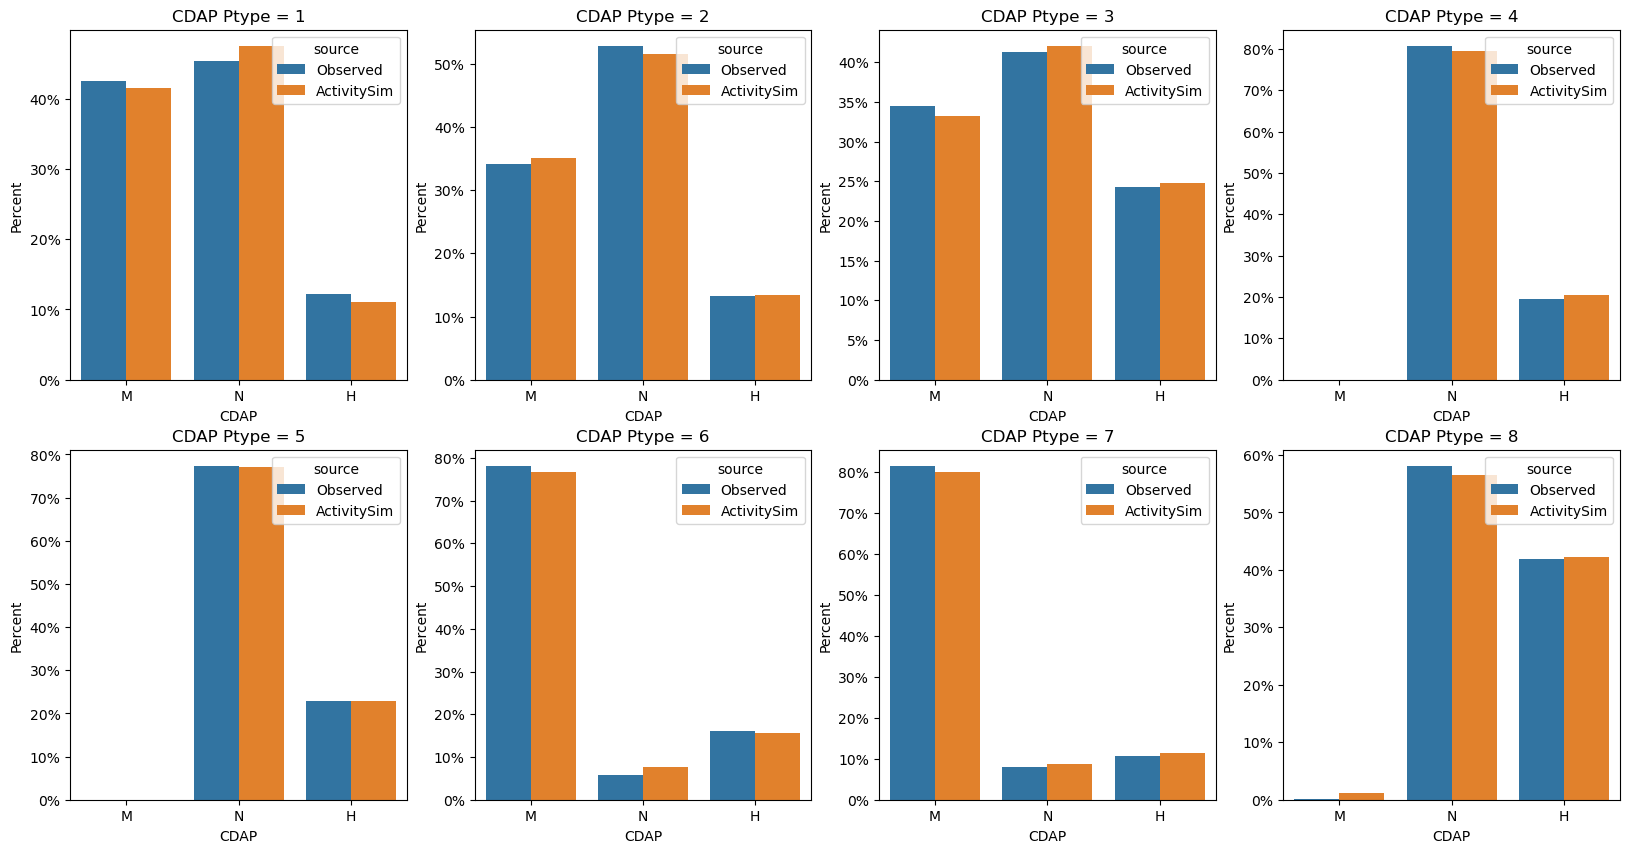

In [3]:
source_dict = {'ObsPct': 'Observed', 'ModelPct': 'ActivitySim'}
plot_data = pd.melt(ptype_compare[['ptype', 'cdap_activity', 'ObsPct', 'ModelPct']], value_name = 'percent', value_vars = ['ObsPct', 'ModelPct'], id_vars = ['ptype', 'cdap_activity'])
plot_data['source'] = plot_data['variable'].map(source_dict)
plot_data['cdap_level'] = plot_data['cdap_activity'].map(CDAP_LEVEL)
fig, ax = plt.subplots(2, 4, figsize=(20, 10))
plot_idx = 240
for ptype in np.arange(1, 9):
    ax = plt.subplot(plot_idx + ptype)
    plot_dat = pd.DataFrame({'cdap_level': [1, 2, 3]}).merge(plot_data[plot_data['ptype'] == ptype], how = 'left', on = 'cdap_level')
    sns.barplot(data = plot_dat, x = 'cdap_level', y = 'percent', hue = 'source')
    plt.title(f"CDAP Ptype = {ptype}")
    # plt.xticks(fontsize=16, rotation = 90)
    # plt.yticks(fontsize=16)
    plt.ylabel('Percent')
    plt.xlabel('CDAP')
    ax.set_xticks([0, 1, 2], labels = ['M', 'N', 'H'])
    ax.yaxis.set_major_formatter(matplotlib.ticker.StrMethodFormatter('{x:,.0%}'))


# Notes

The constants were updated manually since they are hard-coded in the model specification file